In [10]:
from Imports import *
from Preprocessing import *

In [ ]:
#SETTINGS:

gammas = [50, 45, 40, 35, 30]

encodingSettings = {
    "zzEncoding":True,
    "zzEncoding_full_entangle":True,
}

classicalKernelSettings = {
    "rbf":True,
    "polynomial":False,
}

In [ ]:
# Data paths
TRAIN_FILE = '../Data/X_train_scaled.csv'
TEST_FILE = '../Data/X_test_scaled.csv'
LABEL_TRAIN_FILE = '../Data/2025-Quantathon-Tornado-Q-training_data-640-examples.xlsx'
LABEL_TEST_FILE = '../Data/2025-Quantum-Tornado-Q-test_data-200-examples.xlsx'
SAVE_LOCATION = "./kernels/"

df_train = pd.read_csv(TRAIN_FILE)
df_test = pd.read_csv(TEST_FILE)

df_label_train_class = pd.read_excel(LABEL_TRAIN_FILE)["ef_class"]

df_label_test_class = pd.read_excel(LABEL_TEST_FILE)["ef_class"]

df_label_train_class, df_train = removeWeakTornados(df_label_train_class, df_train)
df_label_test_class, df_test = removeWeakTornados(df_label_test_class, df_test)

# Renormalize Data
df_train = df_train.drop(df_train.columns[-1], axis = 1) 
df_train = np.tanh(df_train)
df_test = df_test.drop(df_test.columns[-1], axis = 1)
df_test = np.tanh(df_test)

print(f"✓ Training data loaded: {df_train.shape[0]} rows, {df_train.shape[1]} columns")
print(f"✓ Test data loaded: {df_test.shape[0]} rows, {df_test.shape[1]} columns")

✓ Training data loaded: 69 rows, 8 columns
✓ Test data loaded: 21 rows, 8 columns


In [13]:
kernels_train = {}
kernels_test = {}
for kernel in encodingSettings:
    if encodingSettings[kernel]:
        kernels_train[kernel] = np.load(SAVE_LOCATION + kernel + "_kernel_train.npy", allow_pickle=True)
        kernels_test[kernel] = np.load(SAVE_LOCATION + kernel + "_kernel_test.npy", allow_pickle=True)

classical_kernels_train = {}
classical_kernels_test = {}
for kernel in classicalKernelSettings:
    if classicalKernelSettings[kernel]:
        for gamma in gammas:
            classical_kernels_train[kernel, gamma] = np.load(SAVE_LOCATION + kernel + f"_gamma={gamma}_kernel_train.npy", allow_pickle=True)
            classical_kernels_test[kernel, gamma] = np.load(SAVE_LOCATION + kernel + f"_gamma={gamma}_kernel_test.npy", allow_pickle=True)

kernels_train = kernels_train | classical_kernels_train
kernels_test = kernels_test | classical_kernels_test

In [15]:
classifiers = {}
for kernel in kernels_train:
        if type(kernel) != tuple:
                svc = SVC(kernel="precomputed", class_weight="balanced", probability=True)
                svc.fit(kernels_train[kernel], df_label_train_class)
                classifiers[kernel] = svc
        else:
                svc = SVC(kernel="precomputed", class_weight="balanced", probability=True)
                svc.fit(classical_kernels_train[kernel].item()[kernel[1]], df_label_train_class)
                classifiers[kernel] = svc

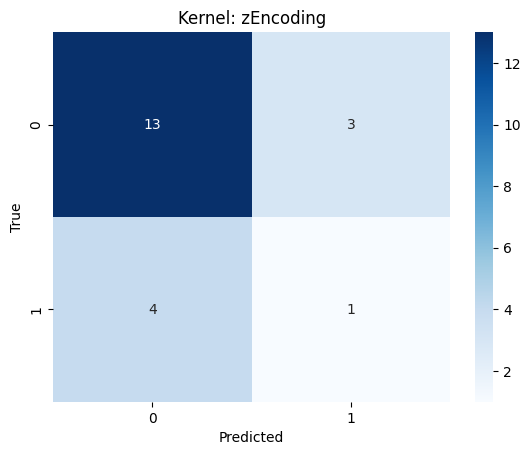

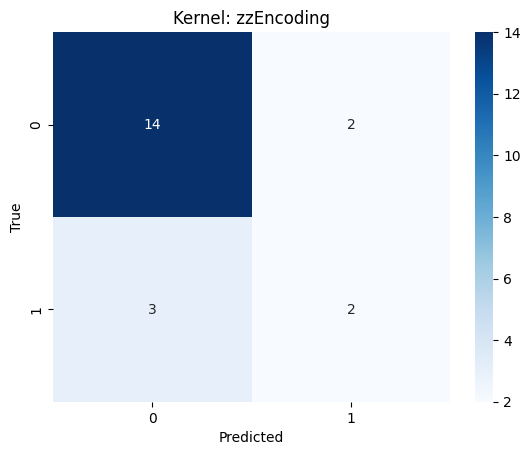

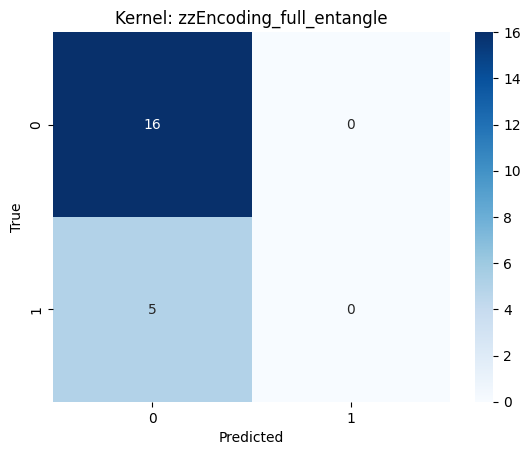

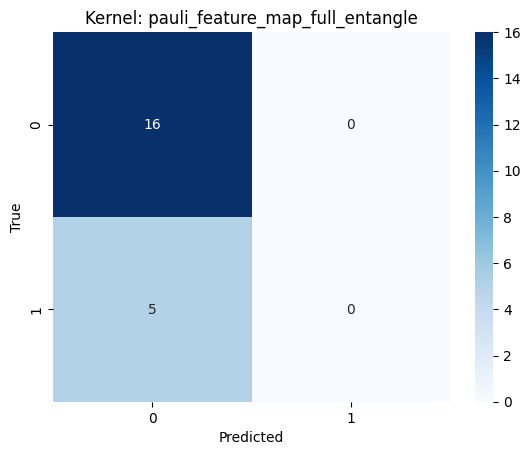

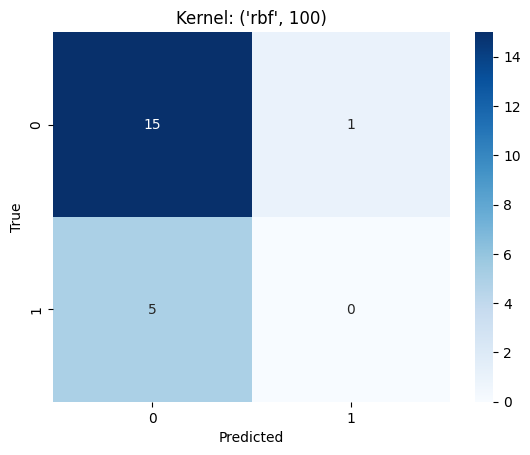

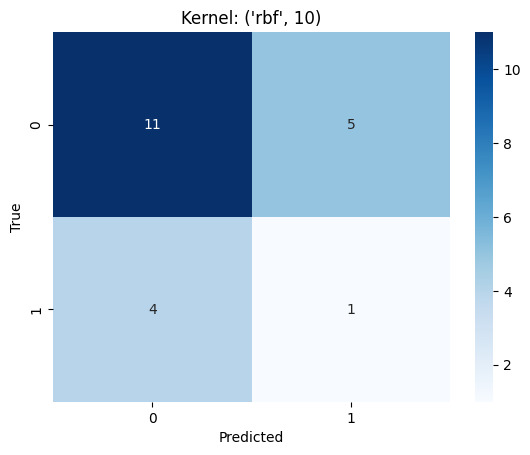

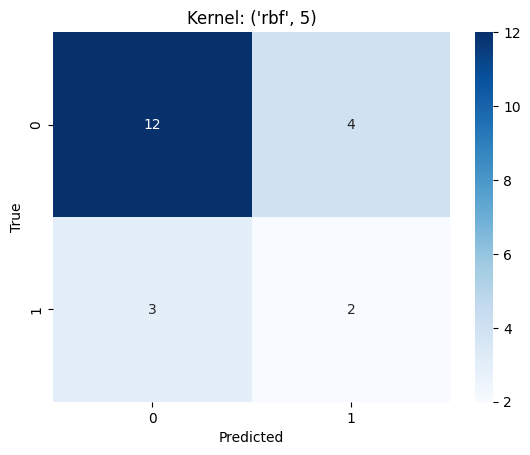

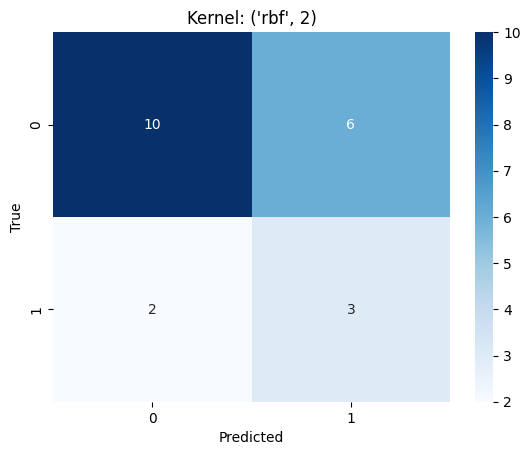

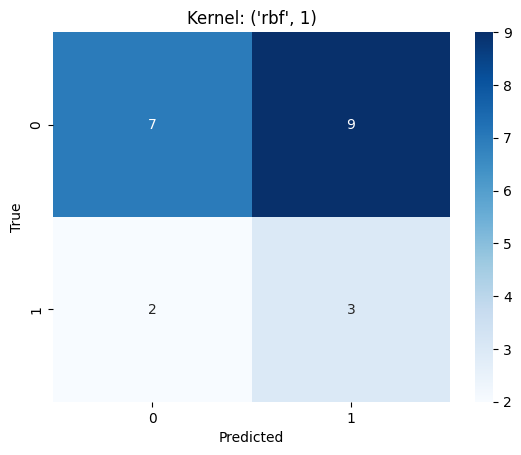

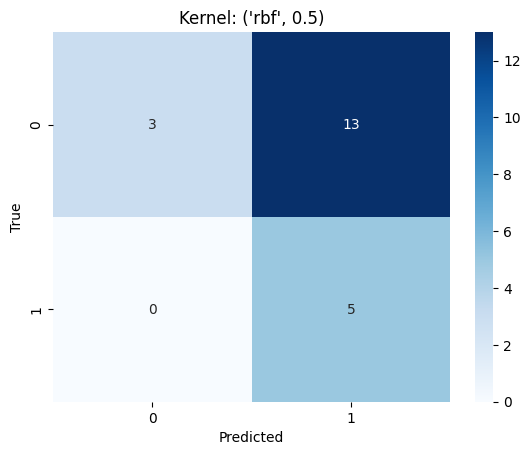

In [16]:
#Analyze Data:
# Predictions
predictions = {}
probs = {}
for classifier in classifiers:
    if type(classifier) != tuple:
        predictions[classifier]=classifiers[classifier].predict(kernels_test[classifier])
        probs[classifier]=classifiers[classifier].predict_proba(kernels_test[classifier])
    else:
        predictions[classifier]=classifiers[classifier].predict(kernels_test[classifier].item()[classifier[1]])
        probs[classifier]=classifiers[classifier].predict_proba(kernels_test[classifier].item()[classifier[1]])

# Confusion matrix
cm = {}
for prediction in predictions:  
    cm[prediction] = confusion_matrix(df_label_test_class, predictions[prediction])

# Plot with seaborn
for c in cm:
    sns.heatmap(cm[c], annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Kernel: {c}")
    plt.savefig(f"figs/Kernel{c}.png")
    plt.show()

In [ ]:
cm = {}
for prediction in predictions:  
    cm[prediction] = accuracy_score(df_label_test_class.to_numpy(), predictions[prediction])
    fpr, tpr, thresholds = roc_curve(df_label_test_class.to_numpy(), probs[prediction][:, 1])
    auc = roc_auc_score(df_label_test_class.to_numpy(), probs[prediction][:, 1])


df = pd.DataFrame(cm, index=[0])
sns.barplot(data=df)
plt.show()

[0.24700089 0.25258861 0.39377391 0.25323283 0.38377839 0.077234
 0.15865345 0.22252852 0.39761947 0.2883555  0.10328633 0.374181
 0.34913058 0.3701091  0.64478071 0.41772375 0.52749564 0.14216648
 0.3229108  0.24347246 0.22751232]


ValueError: Found input variables with inconsistent numbers of samples: [21, 1]

In [ ]:
#ROC/AUC Graphs

In [ ]:
#Cross-Validation with QSVC or Classical SVC


In [ ]:
#Kernel Spectrum / Eigenvalues? Maybe.


In [ ]:
#Sensitivity Analysis
